In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

!pip install --upgrade pip
!pip install sentencepiece
import sentencepiece
import tensorflow as tf
from transformers import XLMRobertaTokenizer, BertTokenizer, TFBertModel, TFXLMRobertaModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.0 MB/s eta 0:00:0000:01


E0000 00:00:1721797010.936079      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D0724 04:56:50.944500561      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0724 04:56:50.944514253      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0724 04:56:50.944517588      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0724 04:56:50.944520003      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0724 04:56:50.944522272      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

In [2]:
data = pd.read_csv("../input/emotional-classification/dev_data.csv")
label_map = {value:key for key,value in 
             data['label'].drop_duplicates().reset_index(drop= True).to_dict().items()}
data['label'] = data['label'].map(label_map)

data.head()

,text,label
0,i usually wear my hair in a twist out and when...,0
1,i feel so irritated and rejected by it or is g...,1
2,i can feel it disturbed within me,2
3,im talking about down right i feel like slappi...,1
4,i almost feel like im messing with a precious ...,0


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel('ERROR')

In [3]:
# setting up a TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1721797044.928292      13 service.cc:145] XLA service 0x5a202ad049d0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721797044.928350      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1721797044.928355      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1721797044.928358      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1721797044.928362      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1721797044.928365      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1721797044.928367      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1721797044.928370      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1721797044.928373      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [4]:
model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertModel.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [5]:
def encode_sentence(ss, max_len= 10):
    tokens = tokens = ['[CLS]'] + tokenizer.tokenize(ss) + ['[SEP]']
    if max_len > len(tokens):
        # PAD tensor
        tokens=tokens +['[PAD]' for _ in range(max_len-len(tokens))]  
    return tokenizer.convert_tokens_to_ids(tokens[:max_len])

def bert_encode(sentences, tokenizer, max_len= 10):
        
    input_word_ids = tf.convert_to_tensor([encode_sentence(ss, max_len) for ss in sentences])
    input_mask = tf.cast(tf.convert_to_tensor([encode_sentence(ss, max_len) 
                                               for ss in sentences])>0, tf.int32)
    input_type_ids = tf.zeros_like(input_word_ids)
    
    inputs = {
      'input_word_ids': input_word_ids,
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}
    
    return inputs

In [6]:
def build_model(max_len):
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    
    maxpool = tf.keras.layers.GlobalAveragePooling1D(name= 'maxpool')(embedding)
    output = tf.keras.layers.Dense(6, activation='softmax')(maxpool)
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [7]:
max_len= 50
with strategy.scope():
    model = build_model(max_len)
    model.summary()

I0000 00:00:1721797084.366166      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initializ

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 50)]                 0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 50)]                 0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 50)]                 0         []                            
 )                                                                                                
                                                                                              

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], 
                                                    train_size= 100000, stratify= data['label'])

In [15]:
train_input = bert_encode(X_train, tokenizer, max_len)
test_input = bert_encode(X_test, tokenizer, max_len)

In [16]:
history = model.fit(train_input, y_train.values, epochs = 5, verbose = 1, 
                    validation_split = 0.2, batch_size= 64)

Epoch 1/5


2024-07-24 05:03:49.090972: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
I0000 00:00:1721797431.035568     841 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(81ba79daf4fcab45:0:0), session_name()
I0000 00:00:1721797458.499834     841 tpu_compile_op_common.cc:245] Compilation of 81ba79daf4fcab45:0:0 with session name  took 27.464214875s and succeeded
I0000 00:00:1721797458.586982     841 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(81ba79daf4fcab45:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_13980405344634056525", property.function_library_fingerprint = 3666206981080404943, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, 

1250/1250 [==============================] - ETA: 0s - loss: 0.3020 - accuracy: 0.8788

2024-07-24 05:05:54.795706: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
I0000 00:00:1721797555.526563     821 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(24c1e3875f167866:0:0), session_name()
I0000 00:00:1721797559.405599     821 tpu_compile_op_common.cc:245] Compilation of 24c1e3875f167866:0:0 with session name  took 3.878983223s and succeeded
I0000 00:00:1721797559.433692     821 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(24c1e3875f167866:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_13560851768716835750", property.function_library_fingerprint = 15057190498530311944, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topolo

1250/1250 [==============================] - 188s 87ms/step - loss: 0.3020 - accuracy: 0.8788 - val_loss: 0.1316 - val_accuracy: 0.9312
Epoch 2/5


I0000 00:00:1721797567.281095     781 tpu_compile_op_common.cc:245] Compilation of ab63ab51902e77ab:0:0 with session name  took 3.172763774s and succeeded
I0000 00:00:1721797567.302124     781 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ab63ab51902e77ab:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_13560851768716835750", property.function_library_fingerprint = 15057190498530311944, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,50,;4,50,;4,50,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1721797567.302154     781 tpu_compilation_cache_interface.cc:541] After adding entry for key ab63

1250/1250 [==============================] - 93s 75ms/step - loss: 0.1182 - accuracy: 0.9367 - val_loss: 0.1176 - val_accuracy: 0.9353
Epoch 3/5
1250/1250 [==============================] - 92s 74ms/step - loss: 0.1006 - accuracy: 0.9426 - val_loss: 0.1175 - val_accuracy: 0.9348
Epoch 4/5
1250/1250 [==============================] - 94s 75ms/step - loss: 0.0913 - accuracy: 0.9460 - val_loss: 0.1160 - val_accuracy: 0.9364
Epoch 5/5
1250/1250 [==============================] - 93s 75ms/step - loss: 0.0835 - accuracy: 0.9491 - val_loss: 0.1228 - val_accuracy: 0.9356


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


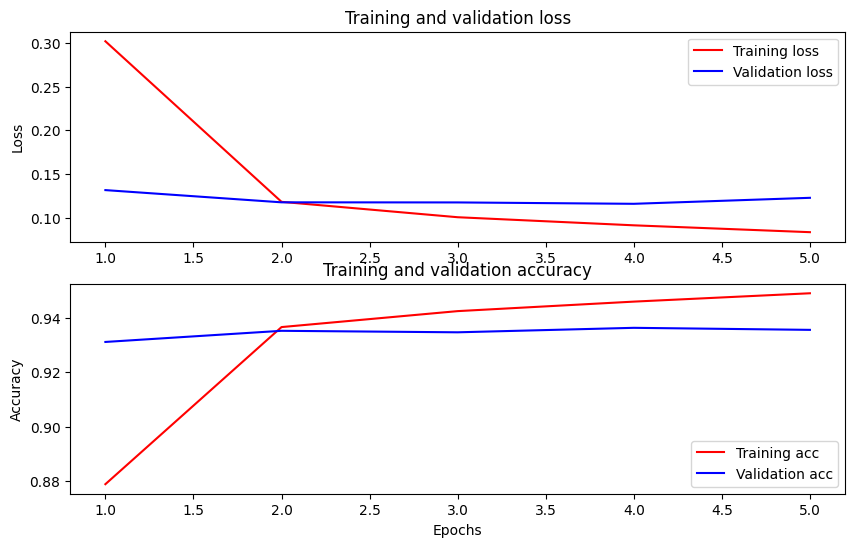

In [17]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [18]:
predictions = np.argmax(model.predict(test_input), axis= 1)

label_inv_map = {v:k for k,v in label_map.items()}
print(classification_report(y_test.map(label_inv_map),pd.Series(predictions).map(label_inv_map)))

2024-07-24 05:13:37.637334: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
I0000 00:00:1721798018.350729     798 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(f74be73e8a05471e:0:0), session_name()


   8/7280 [..............................] - ETA: 1:54  

I0000 00:00:1721798021.487661     798 tpu_compile_op_common.cc:245] Compilation of f74be73e8a05471e:0:0 with session name  took 3.136880332s and succeeded
I0000 00:00:1721798021.512002     798 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(f74be73e8a05471e:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_12075219816801627188", property.function_library_fingerprint = 11945565773545333173, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,50,;4,50,;4,50,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1721798021.512040     798 tpu_compilation_cache_interface.cc:541] After adding entry for key f74b

7277/7280 [============================>.] - ETA: 0s

I0000 00:00:1721798124.809555     796 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(abe255eac5d7e71c:0:0), session_name()


7280/7280 [==============================] - 120s 15ms/step


I0000 00:00:1721798127.840301     796 tpu_compile_op_common.cc:245] Compilation of abe255eac5d7e71c:0:0 with session name  took 3.030702174s and succeeded
I0000 00:00:1721798127.862470     796 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(abe255eac5d7e71c:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_12075219816801627188", property.function_library_fingerprint = 11945565773545333173, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,50,;2,50,;2,50,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1721798127.862501     796 tpu_compilation_cache_interface.cc:541] After adding entry for key abe2

              precision    recall  f1-score   support

       anger       0.94      0.94      0.94     32390
        fear       0.88      0.92      0.90     27463
         joy       0.93      0.97      0.95     78418
        love       0.93      0.75      0.83     18992
     sadness       0.97      0.97      0.97     67437
    surprise       0.82      0.78      0.80      8233

    accuracy                           0.93    232933
   macro avg       0.91      0.89      0.90    232933
weighted avg       0.93      0.93      0.93    232933

